In [3]:
import pandas as pd
import numpy as np
import re

In [4]:
data = pd.read_excel('Healthcare_dataset.xlsx', engine='openpyxl', sheet_name='Dataset', na_values=['Unknown', 'Other/Unknown'])

In [5]:
#Map values to numbers
columns_map = {}
columns_decode = {}
for col in data.columns:
    if str(data[col].dtype) == 'object':  #If it's a categorical variable
        val_map = {}
        val_decode = {}
        mapped_value = 0
        for idx, val in enumerate(data[col].unique()): 
            not_na = True
            if type(val) == float:
                not_na = (np.isnan(val) != True)
            if  not_na == True: #If the value is not NaN add it to the mapping
                val_map[val] = mapped_value 
                val_decode[mapped_value] = val
                mapped_value += 1
            columns_map[col] = val_map
            columns_decode[col] = val_decode
            
print(columns_map['Ethnicity'])

{'Not Hispanic': 0, 'Hispanic': 1}


In [6]:
#dealing with missing data
from sklearn.impute import KNNImputer

df = data.copy()
#Using Mapping to encode data
for col in df.columns:
    if str(df[col].dtype) == 'object':
        df[col] = df[col].map(columns_map[col])
   
df_filled = df.copy()
imputer= KNNImputer(n_neighbors=5)
df_filled = imputer.fit_transform(df_filled)
df_filled = pd.DataFrame(df_filled, columns=df.columns).apply(round)
df_filled.isna().any().any()

False

# Machine Learning Model Random Forest

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

X = df_filled.loc[:, df_filled.columns.difference(['Ptid', 'Persistency_Flag'])] #Design Matrix
y = df_filled['Persistency_Flag'] #Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.816147859922179


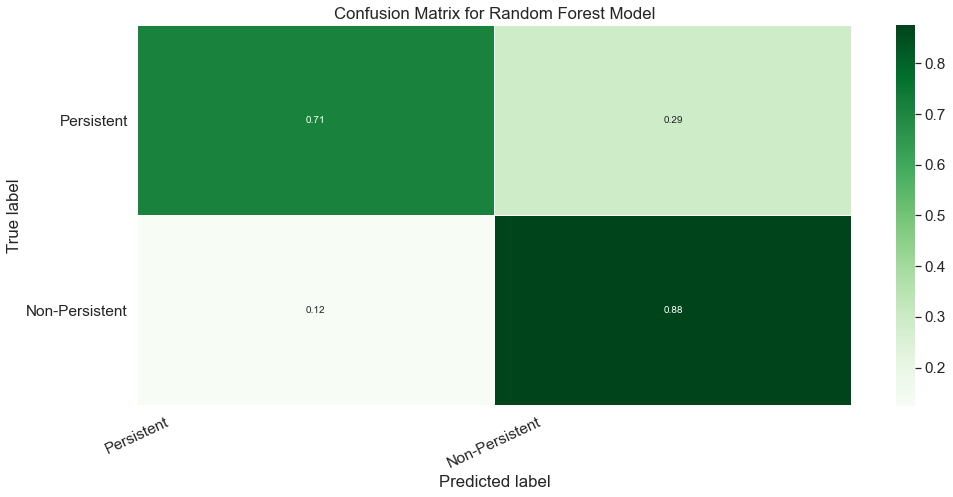

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
#Confusion Matrix
matrix = metrics.confusion_matrix(y_test, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = [columns_decode['Persistency_Flag'][0], columns_decode['Persistency_Flag'][1]]
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

In [10]:
# View the classification report for test data and predictions
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.76      0.71      0.74       371
         1.0       0.84      0.88      0.86       657

    accuracy                           0.82      1028
   macro avg       0.80      0.79      0.80      1028
weighted avg       0.81      0.82      0.81      1028



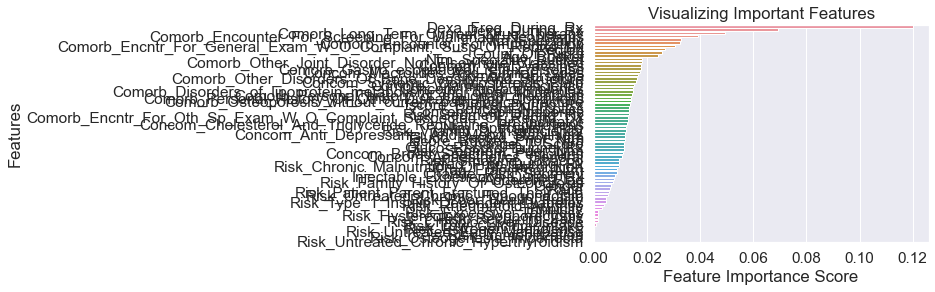

In [11]:
#Find most important features to the model
feature_imp = pd.Series(clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

sns.barplot(x=feature_imp, y=feature_imp.index)

plt.rcParams['figure.figsize'] = [18, 6]
plt.rcParams['figure.dpi'] = 100

plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

In [13]:
#Serlialize model using pickle
import pickle
with open('Omar_RF_model.sav', 'wb') as file:
    pickle.dump(clf, file)